# Building decision trees

Well, actually, we'll fake finding optimal split as that is your project.

In [64]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from sklearn import tree
from dtreeviz.trees import *

## One possible tree framework

In [65]:
from lolviz import *

class DecisionNode:
    def __init__(self,split): # split chosen from x values
        self.split = split

class LeafNode:
    def __init__(self,y):
        self.y = y

## 1D decision tree stumps

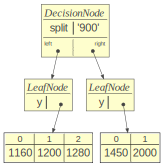

In [66]:
root = DecisionNode(900)                 # split on x at 900
root.left = LeafNode([1160, 1200, 1280]) # 3 y values in leaf
root.right = LeafNode([1450,2000])
treeviz(root)

In [67]:
df = pd.DataFrame()
df["sqfeet"] = [750, 800, 850, 900,950]
df["rent"] = [1160, 1200, 1280, 1450,1300]
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,1300


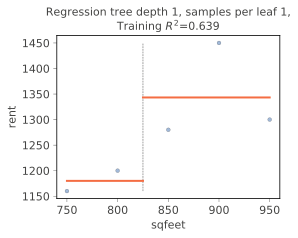

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
X, y = df.sqfeet.values, df.rent.values
t = rtreeviz_univar(ax,
                    X, y,
                    max_depth=1,
                    feature_name='sqfeet',
                    target_name='rent',
                    fontsize=11,
                    colors={'scatter_edge': 'black'})

In [69]:
def fit(x, y):
    """
    We train on the (x,y), getting split of single-var x that
    minimizes variance in subregions of y created by x split.
    Return root of decision tree stump
    """
    split = find_best_split(x,y)
    root = DecisionNode(split)
    root.left = LeafNode(y[x<split])
    root.right = LeafNode(y[x>=split])
    return root

def find_best_split(x,y):
    "Fake it by picking random value from x (ignoring y)"
    i = np.random.randint(0, len(x))
    return x[i]

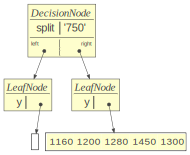

In [70]:
t = fit(X, y)
treeviz(t)

## 1D decision tree

In [71]:
def fit(x, y):
    """
    We train on the (x,y), getting split of single-var x that
    minimizes variance in subregions of y created by x split.
    Return root of decision tree stump
    """
    if len(x)==1:
        return LeafNode(y)
    split = find_best_split(x,y)
    if np.sum(x<split)==0 or np.sum(x>=split)==0: # don't allow empty subregion(s)
        return LeafNode(y)
    t = DecisionNode(split)
    t.left  = fit(x[x<split],  y[x<split])
    t.right = fit(x[x>=split], y[x>=split])
    return t

def find_best_split(x,y):
    "Fake it by picking random value from x (ignoring y)"
    if len(x)<1:
        return np.inf # can't split a single value
    i = np.random.randint(0, len(x))
    return x[i]

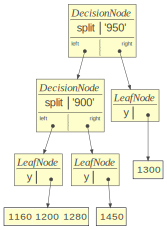

In [72]:
t = fit(X, y)
treeviz(t)

### Tree structure

n=506


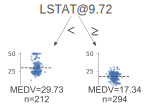

In [73]:
boston = load_boston()
X = boston.data
y = boston.target
features = boston.feature_names
print(f"n={len(y)}")

t = DecisionTreeRegressor(min_samples_leaf=200)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='MEDV',
       feature_names=features,
         fancy=False)

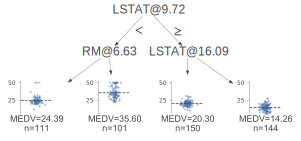

In [74]:
t = DecisionTreeRegressor(min_samples_leaf=100)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='MEDV',
       feature_names=features,
         fancy=False)

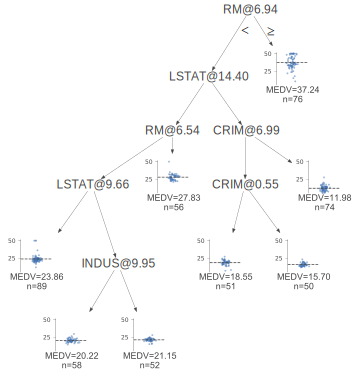

In [75]:
t = DecisionTreeRegressor(min_samples_leaf=50)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='MEDV',
       feature_names=features,
         fancy=False)

In [76]:
df_cars = pd.read_csv("data/cars.csv")
X, y = df_cars.drop('MPG', axis=1), df_cars['MPG']
df_cars.head(3)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436


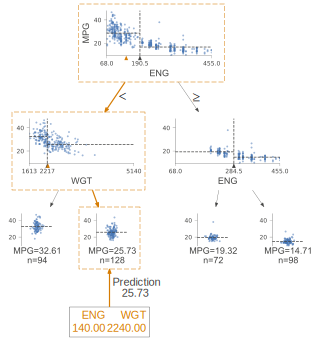

In [77]:
t = DecisionTreeRegressor(max_depth=2)
t.fit(X[['ENG','WGT']],y)
dtreeviz(t,
       X_train=X[['ENG','WGT']],
       y_train=y,
       target_name='MPG',
       feature_names=['ENG','WGT'],
       X=np.array([140,2240]))

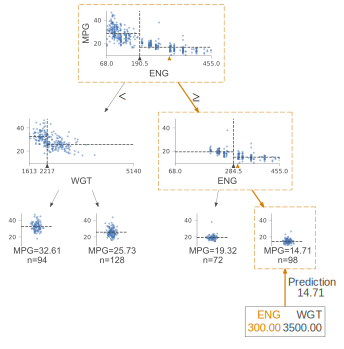

In [78]:
dtreeviz(t,
       X_train=X[['ENG','WGT']],
       y_train=y,
       target_name='MPG',
       feature_names=['ENG','WGT'],
       X=np.array([300,3500]))

## Decision tree stumps

In [83]:
class TreeNode: # acts as decision node and leaf. it's a leaf if split is None
  def __init__(self, split=None, prediction=None, left=None, right=None):
    self.split = split
    self.prediction = prediction
    self.left = left
    self.right = right
  def __repr__(self):
    return str(self.value)
  def __str__(self):
    return str(self.value)

In [99]:
def stumpfit(x, y):
    if len(x)==1: # if one x value, make leaf
        return TreeNode(prediction=y[0])
    split = (min(x) + max(x)) / 2 # midpoint
    t = TreeNode(split)
    t.left = TreeNode(prediction=np.mean(y[x<split]))
    t.right = TreeNode(prediction=round(np.mean(y[x>=split]),2))
    return t

In [100]:
df = pd.DataFrame()
df["sqfeet"] = [750, 800, 850, 900,950]
df["rent"] = [1160, 1200, 1280, 1450,1300]
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,1300


In [101]:
X, y = df.sqfeet.values, df.rent.values

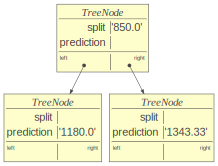

In [102]:
stump = stumpfit(X,y)
treeviz(stump)

### Extend to full tree not stump

In [89]:
def treefit(x, y):
    if len(x)==1: # if one x value, make leaf
        return TreeNode(prediction=y[0])
    split = (min(x) + max(x)) / 2 # midpoint
    t = TreeNode(split)
    t.left  = treefit(x[x<split],  y[x<split])
    t.right = treefit(x[x>=split], y[x>=split])
    return t

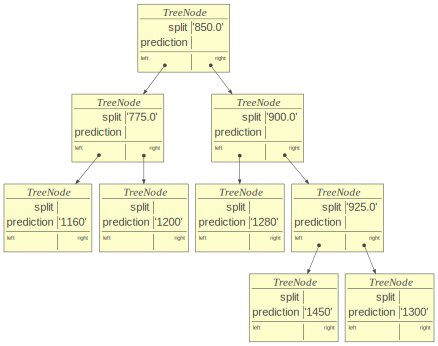

In [90]:
root = treefit(X,y)
treeviz(root)